In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Module 2: Gradient Descent

Brute-force search does not scale beyond a few free parameters, can we do better?

## Null Model

Let's first look at how the loss function changes as $c$ changes. We can adapt the brute-force search algorithm from Module 1 to visualize the loss function over values of $c$.

In [9]:
# read data
data = np.load('code/day2/fake_data.npz')
# assign X and y numpy arrays
X, y = data['X'], data['y']

Text(0, 0.5, 'MSE')

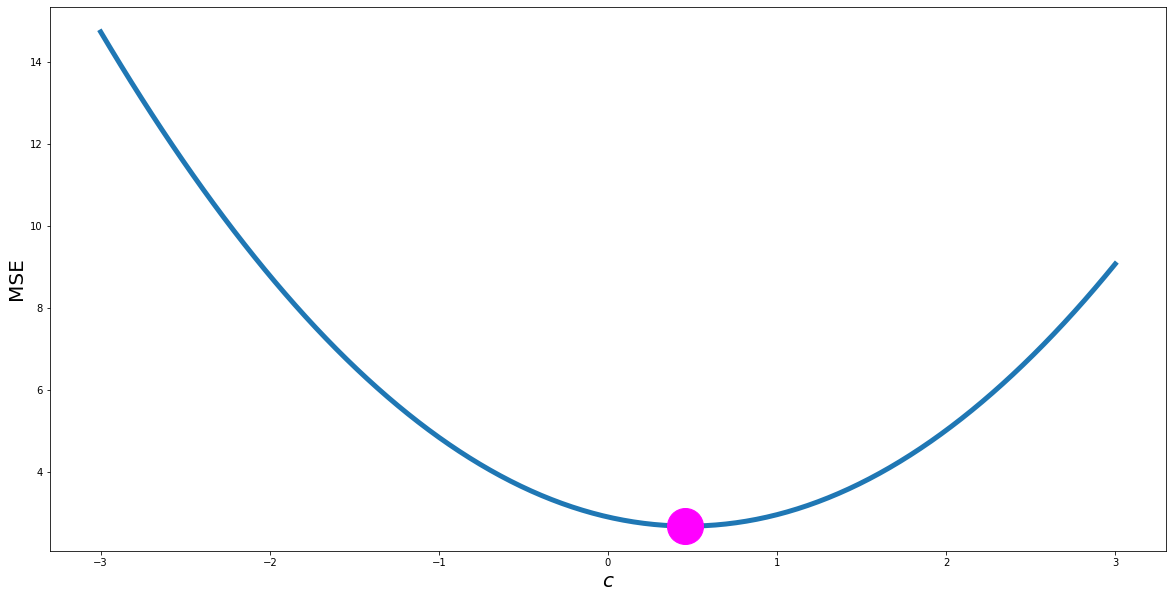

In [9]:
# initialize the search "grid": 100 evenly-spaced points from -3 to 3
cs = np.linspace(-3, 3, 100)

# initialize an empty array to hold mse value for each candidate c
mses = []

# for each candidate c
for c in cs:
    
    # predict the value at the given x values (just a constant)
    yhat = np.ones_like(X) * c
    
    # compute mse
    mse = np.mean( np.square(yhat - y) )
    
    # add to results
    mses.append(mse)

# argmin returns the index of the element with the lowest value
best_ix = np.argmin(mses)

# using that index we can get the best c value
best_c = cs[best_ix]

# now visualize the landscape
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(cs, mses, linewidth=5)
ax.plot([best_c], mses[best_ix], marker='o', color='magenta', markersize=36)
ax.set_xlabel('$c$', fontsize=20)
ax.set_ylabel('MSE', fontsize=20)

Imagine dropping a ball at some random value of $c$, where would the ball go?

- If the curve is flat, the ball stays
- If the curve is pointing up, the ball rolls backwards
- If the curve is pointing down, the ball rolls forwards

**Idea**: Simulate the behavior of the ball. The ball stops moving when it is at a minimum. The location of the ball when it stops corresponds to the best value of $c$.

- To do this, we need to know the _steepness_ of the curve at value of $c$.
- The _steepness_ corresponds to the slope, which is just the first derivative of the loss function

$$\frac{d}{dc}\mathcal{L}(\mathbf{y},\hat{\mathbf{y}})=\frac{1}{N}\sum_{i}\frac{d}{dc}\left(y_{i}-\hat{y}_{i}\right)^{2}$$

$$\frac{d}{dc}\left(y_{i}-\hat{y}_{i}\right)^{2}=2(\hat{y}_{i}-y_{i})$$

* The slope at a given point $i$ is positive if the model over-predicts
* The slope at a given point $i$ is negative if the model under-predicts

**We call the derivative of the loss function the Gradient**. Let's plot the gradient of the loss function of the null model.


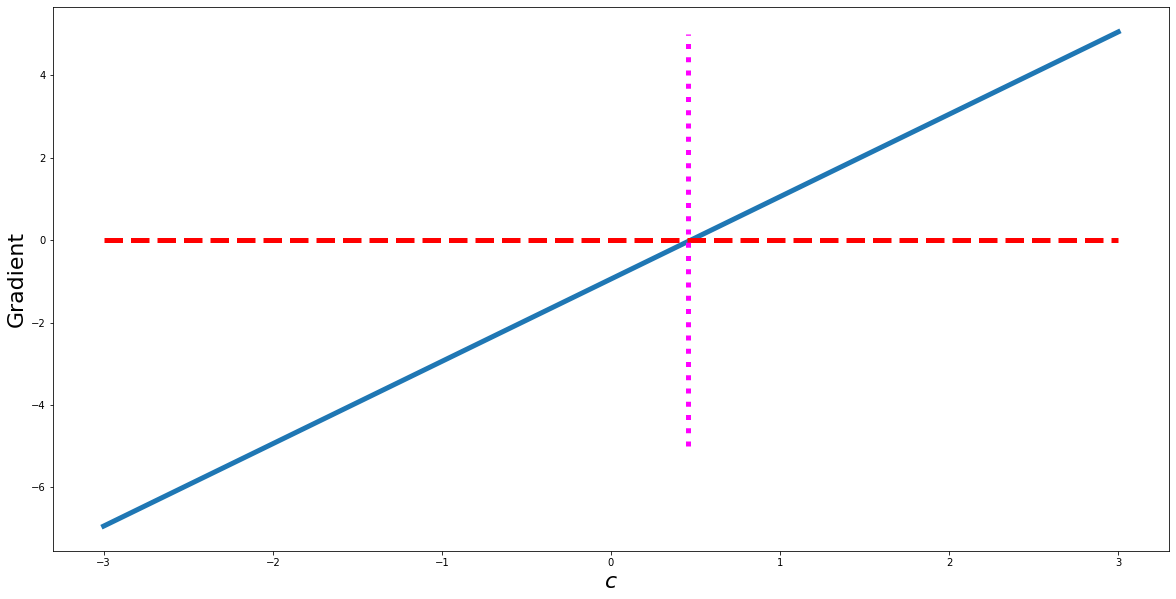

In [18]:
grads = []
for c in cs:
    
    # first compute the prediction yhat = c
    yhat = np.ones_like(X) * c 
    
    # now compute the gradient
    grad = np.mean( 2 * (yhat - y) )
    grads.append(grad)

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(cs, grads, linewidth=5)
ax.plot(cs, np.zeros_like(cs), linewidth=5, color='r', linestyle='dashed')
ax.plot([best_c, best_c], [-5, 5], linewidth=5, color='magenta', linestyle='dotted')
ax.set_xlabel('$c$', fontsize=22)
ax.set_ylabel('Gradient', fontsize=22)
plt.show()

* The red line is the zero-gradient line and the magenta line is the location of the minimum. 
* The minimum occurs when the gradient is zero.

<font color='magenta'>**Idea for an algorithm**:</font>

If the gradient is negative, increase $c$. And if it is positive, decrease $c$.

**<font color='red'>Why Not Just Use Calculus?</font>**

* In this case, we can analytically find the minimum of the loss function without any optimization
* But in most interesting models, the analytical solution is difficult or non-existent

### Gradient Descent

Gradient descent is an algorithm for finding a <font color='red'>**local**</font> minimum of a function numerically. 

1. Initialize $c$ to a random value
2. Repeat until convergence:
    1. Compute model predictions $\hat{y}$
    2. Compute the gradient at those predictions $\frac{d}{dc}\mathcal{L}(\mathbf{y},\hat{\mathbf{y}})$
    3. Update $c$ by moving in the <font color='red'>opposite</font> direction of the gradient:
    
$$c:=c-\eta\frac{d}{dc}\mathcal{L}(\mathbf{y},\hat{\mathbf{y}})$$

Here $\eta$ is the learning rate. It controls the size of the steps that the algorithm makes. It is a very important parameter that affects the speed and quality of optimization, as we'll see now.


In [81]:
# random number generation module
import numpy.random as rng

# generate random normal variable with mean 0 and std 1
c = rng.randn()
#c = 2

# number of iterations
N = 15

# learning rate
# try 0.1, 0.9, and 1
eta = 0.1

# array to hold steps that the algorithm made so that
# we can visualize them later
steps = []
steps_mse = []
for i in range(N):
    
    # compute model predictions
    yhat = np.ones_like(X) * c 
    
    # compute gradient at those predictions
    grad = np.mean( 2 * (yhat - y) )
    
    # update
    c = c - eta * grad
    
    steps.append(c)
    
    # compute mse at this new c (need to recompute yhat)
    yhat = np.ones_like(X) * c
    steps_mse.append(np.mean(np.square(yhat - y)))
    
print("Best c: %0.2f, mse: %0.4f" % (c, steps_mse[-1]))

Best c: 0.54, mse: 2.6773


Now, let's plot the steps that the algorithm made. Try different values of $\eta$ and see what happens.

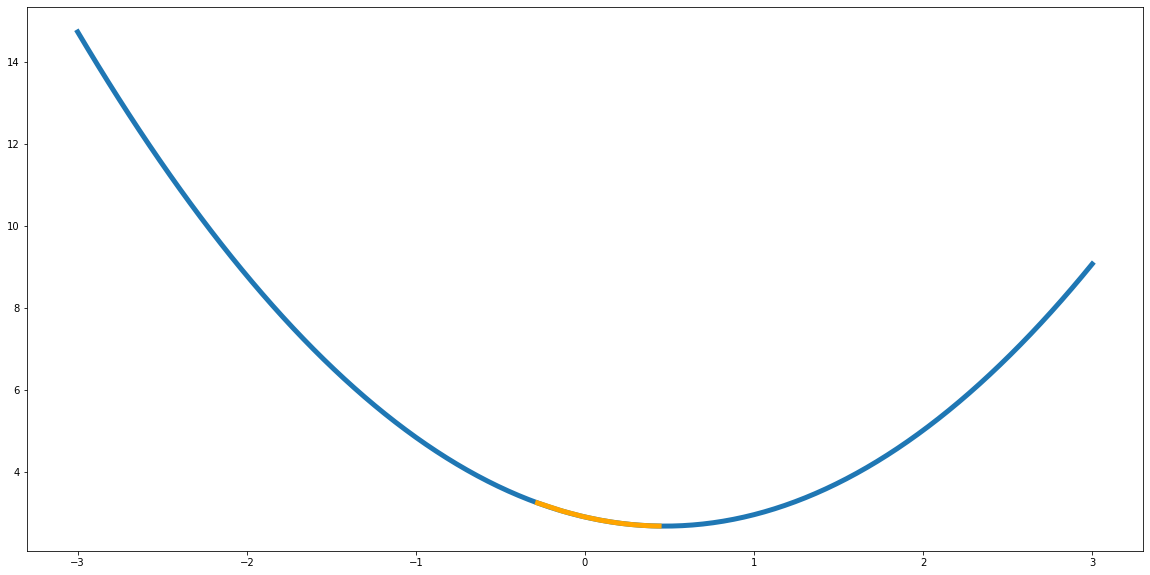

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.plot(cs, mses, linewidth=5)
ax.plot(steps, steps_mse, linewidth=5, color='orange')

* For a small learning rate, the model is too careful; it takes too long to train
* For a large learning rate, the model overshoots the local minima and potentially never converges
* There is no universal optimal learning rate, it depends on the model, data, and loss function
* There are schemes that adapt the learning rate: start with a large rate then reduce as learning progresses
* For now, we'll just use a fixed learning rate.

## Linear Model

* Let's take a look at the loss landscape of the linear model from Module 1. Remember, the model has two parameters, $\beta_0$ and $\beta_1$, so the loss landscape is three dimensional.
* Again, we can adapt the brute-force search code from Module 1 to visualize the loss landscape. But we'll introduce a change that will make it easier to visualize the loss surface.
* This change requires numpy's `meshgrid` function. Meshgrid accepts multiple arrays and returns all possible combinations of their elements.

In [62]:
a = [1, 2, 3]
b = [4, 5, 6]
C1, C2 = np.meshgrid(a, b)

[[1 2 3]
 [1 2 3]
 [1 2 3]]
[[4 4 4]
 [5 5 5]
 [6 6 6]]


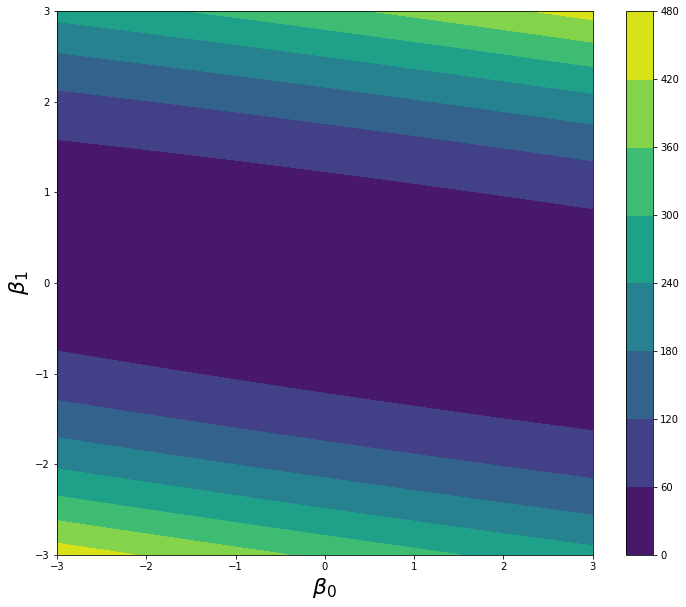

In [71]:
# initialize the search grid
beta_0s = np.linspace(-3, 3, 100)
beta_1s = np.linspace(-3, 3, 100)

# initialize parameter combinations
B0, B1 = np.meshgrid(beta_0s, beta_1s)

# initialize space to store MSE for each combination
mses = np.zeros_like(B0)

# for each candidate
for i in range(mses.shape[0]):
    for j in range(mses.shape[1]):
        b0, b1 = B0[i, j], B1[i, j]
        
        # predict the value 
        yhat = b0 + b1 * X
        
        mses[i, j] = np.mean(np.square(yhat-y))

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cp = ax.contourf(B0, B1, mses)
ax.set_xlabel(r'$\beta_0$', fontsize=22)
ax.set_ylabel(r'$\beta_1$', fontsize=22)
cbar = fig.colorbar(cp, ax=ax)

### Linear Model Gradients

* Unlike the null model, the linear model has two free parameters
* So we need to take the _partial_ derivative of the loss with respect to the parameters

$$\hat{y}_{i}=\beta_{0}+\beta_{1}x_{i}$$
$$\frac{\partial}{\partial\beta_{0}}\left(y_{i}-\hat{y}_{i}\right)^{2}=2(\hat{y}_{i}-y_{i})$$
$$\frac{\partial}{\partial\beta_{1}}(y_{i}-\hat{y}_{i})^{2}=2(\hat{y}_{i}-y_{i})x_{i}$$

Armed with the gradients, we can implement gradient descent for the linear model.

Best mse: 2.25


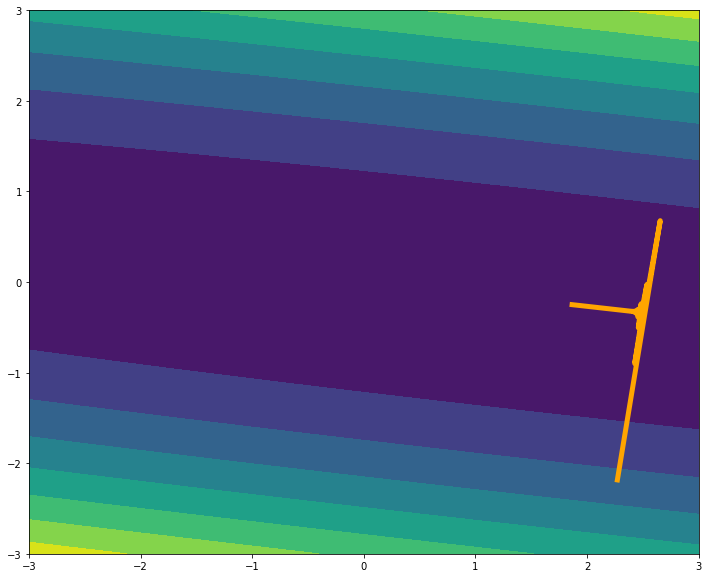

In [111]:
# generate two random normal variable with mean 0 and std 1
beta0, beta1 = rng.randn(2)
beta0, beta1 = [3, 3]

# number of iterations
N = 100

# learning rate
# try 0.001, 0.01, 0.0257
eta = 0.02

# array to hold steps that the algorithm made so that
# we can visualize them later
steps = []
steps_mse = []
for i in range(N):
    
    # compute model predictions
    yhat = X * beta1 + beta0
    
    # compute gradient at those predictions
    beta0_grad = np.mean(2 * (yhat - y))
    beta1_grad = np.mean(2 * (yhat - y) * X)
    
    # update
    beta0 = beta0 - eta * beta0_grad
    beta1 = beta1 - eta * beta1_grad
    
    # track progress
    steps.append([beta0, beta1])
    yhat = X * beta1 + beta0
    steps_mse.append(np.mean(np.square(yhat - y)))

steps = np.array(steps)
print("Best mse: %0.2f" % steps_mse[-1])

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cp = ax.contourf(B0, B1, mses)
ax.plot(steps[:,0], steps[:,1], color='orange', linewidth=5)